# Exploratory Data Analysis (EDA)  

In this notebook, we load our pollen dataset (2D views generated from STL models) and analyze:  

- The number of models in the dataset  
- Visualization of randomly selected samples (left and right views, combined view)  
- Calculation of a simple disparity/depth map using OpenCV Stereo Block Matching  
- Visualization of a histogram of brightness values  

**Note:** The `PollenDataset` class is imported from a separate folder.

In [14]:
import os
import sys
import random
import numpy as np
import matplotlib.pyplot as plt
import cv2
from PIL import Image
from dotenv import load_dotenv

load_dotenv()

sys.path.append("..")
from data import PollenDataset
from data import MeshAnalyzer
from data import MeshCleaner
from data import MeshExplorer

RANDOM_SEED = 1337
np.random.seed(RANDOM_SEED)
random.seed(RANDOM_SEED)

## Dataset-Instance

In [ ]:
DATA_DIR = os.getenv("DATA_DIR_PATH")

dataset = PollenDataset(data_dir=DATA_DIR)
print(f"Number of Pollen Grain Meshes present: {len(dataset)}")

Number of Pollen Grain Meshes present: 207


## Visualizing a Sample  

We select a random sample from the dataset, display the left and right views separately, and combine both images into a single overall view.

Both orthogonal images are taken around the Y-axis, "cameras" are positioned on the X- and Z-axis and are thus *orthogonal*.

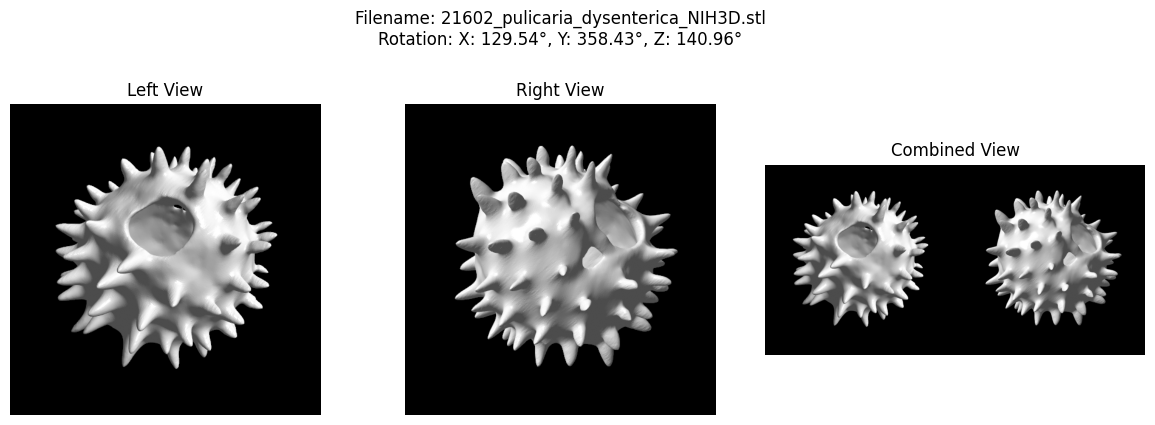

In [18]:
idx = random.randint(0, len(dataset) - 1)
sample = dataset[idx]
left = sample["left_view"]
right = sample["right_view"]
rotation = sample["rotation"]
filename = sample["file_name"]

combined = np.concatenate((left, right), axis=1)

# Create subplots.
fig, axs = plt.subplots(1, 3, figsize=(12, 4))

# Plot the left view.
axs[0].imshow(left, cmap="gray")
axs[0].set_title("Left View")
axs[0].axis("off")

# Plot the right view.
axs[1].imshow(right, cmap="gray")
axs[1].set_title("Right View")
axs[1].axis("off")

# Plot the combined view.
axs[2].imshow(combined, cmap="gray")
axs[2].set_title("Combined View")
axs[2].axis("off")

rotation_str = "X: {0:.2f}\N{DEGREE SIGN}, Y: {1:.2f}\N{DEGREE SIGN}, Z: {2:.2f}\N{DEGREE SIGN}".format(*rotation)

plt.suptitle(f"Filename: {filename}\nRotation: {rotation_str}", y=1.05)

plt.tight_layout()
plt.show()

## Calculation of a Disparity/Depth Map (Proxy)  

Using OpenCV and StereoBM, we compute a simple disparity map from the two views. This can be used as a rough proxy for a depth map – note that this method requires both images to correspond well.  

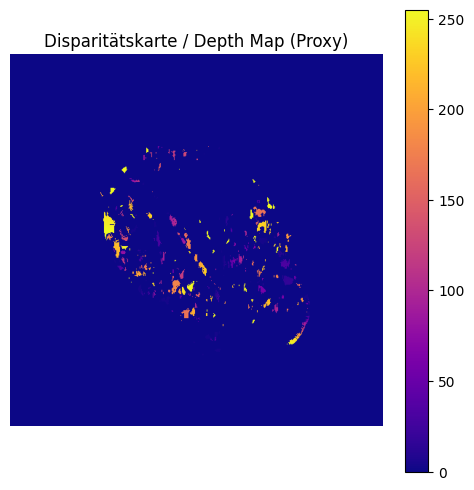

In [4]:
left_np = np.array(left)
right_np = np.array(right)

left_uint8 = cv2.normalize(left_np, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)
right_uint8 = cv2.normalize(right_np, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)

numDisparities = 64
blockSize = 15
stereo = cv2.StereoBM_create(numDisparities=numDisparities, blockSize=blockSize)

disparity = stereo.compute(left_uint8, right_uint8).astype(np.float32)

disp_norm = cv2.normalize(disparity, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX)
disp_norm = np.uint8(disp_norm)

plt.figure(figsize=(6, 6))
plt.imshow(disp_norm, cmap="plasma")
plt.title("Disparitätskarte / Depth Map (Proxy)")
plt.axis("off")
plt.colorbar()
plt.show()

## Meshexploration

In [5]:
analyzer = MeshAnalyzer()
results = analyzer.run_exploration()

Running exploratory analysis of 3D models...


Analyzing models: 100%|██████████| 208/208 [05:03<00:00,  1.46s/it]


Analyzed 208 models.
Watertight models: 119 of 208 (57.2%)


c:\Users\super\Documents\GitHub\sequoia\.venv\Lib\site-packages\pyglet\libs\win32\__init__.py:318: UserWarning: Could not set COM MTA mode. Unexpected behavior may occur.
  warnings.warn("Could not set COM MTA mode. Unexpected behavior may occur.")


Visualization created for 17801_Clematis%20-%20Clematis_NIH3D.stl
Visualization created for 17819_brassica_napus_NIH3D.stl
Visualization created for 17821_Allium%20ursinum%20-%20Wild%20garlic_NIH3D.stl
Visualization created for 21264_solidago_virgaurea_NIH3D.stl
Visualization created for 20608_arenaria_serpyllifolia_NIH3D.stl

Exploratory analysis completed. Results saved in the 'mesh_analysis' folder.


In [ ]:
explorer = MeshExplorer()
# multicore not working at the time for windows
#adv_results = explorer.run_advanced_analysis()

Running advanced 3D model analysis...


Analyzing 3D models: 100%|██████████| 208/208 [05:07<00:00,  1.48s/it]
  File "c:\Users\super\Documents\GitHub\sequoia\.venv\Lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
               ^^^^^^^^^^^^^^^
  File "C:\Users\super\AppData\Local\Programs\Python\Python311\Lib\subprocess.py", line 548, in run
    with Popen(*popenargs, **kwargs) as process:
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\super\AppData\Local\Programs\Python\Python311\Lib\subprocess.py", line 1026, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
  File "C:\Users\super\AppData\Local\Programs\Python\Python311\Lib\subprocess.py", line 1538, in _execute_child
    hp, ht, pid, tid = _winapi.CreateProcess(executable, args,
                       ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^


Advanced analysis completed.


# 3D Model Cleaning Pipeline  

## Overview of the MeshCleaner Class  

The `MeshCleaner` class provides a comprehensive pipeline for processing, analyzing, and cleaning 3D STL models. It is specifically designed for preparing 3D models for machine learning, visualization, or 3D printing.  

## Key Features  

- **Model Analysis**: Computes geometric properties and quality metrics  
- **Model Cleaning**: Removes defects and fills holes  
- **Model Normalization**: Scaling, centering, and orientation adjustments  
- **Visualization**: Generates statistics and charts for model analysis  

## Three-Stage Hole Filling  

The pipeline implements an advanced three-stage strategy for filling holes:  

### 1. Small Holes (`trimesh.fill_holes`)  
- **Method**: Native Trimesh functionality  
- **Best for**: Small, simple holes  
- **Advantages**: Fast and efficient for minor defects  

### 2. Medium-Sized Holes (`vtkFillHolesFilter`)  
- **Method**: VTK library functions  
- **Best for**: Medium-sized holes with moderate complexity  
- **Advantages**: More robust for larger holes where Trimesh fails  

### 3. Complex Holes (`manifold3d`)  
- **Method**: Manifold repair algorithm  
- **Best for**: Complex topology, multiple or large gaps  
- **Advantages**: Can repair severely damaged meshes  

## Workflow  

1. The model is loaded, and basic statistics are collected  
2. Unreferenced vertices are removed  
3. The three-stage hole filling process is applied (if enabled)  
4. Duplicate faces are removed (if enabled)  
5. The model is scaled (if enabled)  
6. The model is centered (if enabled)  
7. The cleaned model is saved  
8. Statistical reports and visualizations are generated  

## Dependencies  

The pipeline utilizes several specialized libraries:  



Die Software prüft nach jeder Bearbeitung, ob die Modelle wasserdicht sind, und erstellt eine Liste von Modellen, die weiterhin Probleme aufweisen. Diese können dann gezielt nachbearbeitet werden.

In [ ]:
cleaner = MeshCleaner()
cleaner.process_all()

Processing Meshes:   0%|          | 0/208 [00:00<?, ?it/s]

Processing 17767_Centaurea%20nigra%20-%20Common%20knapweed_NIH3D.stl: Watertight=True


Processing Meshes:   0%|          | 1/208 [00:03<11:50,  3.43s/it]

✓ Saved: 17767_Centaurea%20nigra%20-%20Common%20knapweed_NIH3D.stl (Vertices: 99186 → 99186, Faces: 198368 → 198368, Watertight: True → True)


Processing Meshes:   1%|          | 2/208 [00:04<07:39,  2.23s/it]

Processing 17775_Allium_schoenoprasum_-_Chive_NIH3D.stl: Watertight=True
✓ Saved: 17775_Allium_schoenoprasum_-_Chive_NIH3D.stl (Vertices: 39836 → 39836, Faces: 79668 → 79668, Watertight: True → True)
Processing 17776_Lobularia%20maritima%20-%20Sweet%20alyssum_NIH3D.stl: Watertight=False
  ✗ Mesh is still not watertight after repair


Processing Meshes:   1%|▏         | 3/208 [00:14<18:57,  5.55s/it]

✗ Saved: 17776_Lobularia%20maritima%20-%20Sweet%20alyssum_NIH3D.stl (Vertices: 90020 → 90020, Faces: 181272 → 181253, Watertight: False → False)
Processing 17777_Rubus%20fruticosus%20-%20Blackberry_NIH3D.stl: Watertight=True


Processing Meshes:   2%|▏         | 4/208 [00:17<15:16,  4.49s/it]

✓ Saved: 17777_Rubus%20fruticosus%20-%20Blackberry_NIH3D.stl (Vertices: 82007 → 82007, Faces: 163942 → 163942, Watertight: True → True)
Processing 17778_Salix%20alba%20-%20Willow_NIH3D.stl: Watertight=True


Processing Meshes:   2%|▏         | 5/208 [00:20<13:18,  3.93s/it]

✓ Saved: 17778_Salix%20alba%20-%20Willow_NIH3D.stl (Vertices: 82380 → 82380, Faces: 164768 → 164768, Watertight: True → True)
Processing 17779_Fragaria%20ananassa%20-%20Garden%20strawberry_NIH3D.stl: Watertight=True


Processing Meshes:   3%|▎         | 6/208 [00:22<11:58,  3.56s/it]

✓ Saved: 17779_Fragaria%20ananassa%20-%20Garden%20strawberry_NIH3D.stl (Vertices: 82614 → 82614, Faces: 165232 → 165232, Watertight: True → True)
Processing 17781_Thymus%20vulgaris%20-%20Common%20thyme_NIH3D.stl: Watertight=True


Processing Meshes:   3%|▎         | 7/208 [00:26<11:24,  3.41s/it]

✓ Saved: 17781_Thymus%20vulgaris%20-%20Common%20thyme_NIH3D.stl (Vertices: 83564 → 83564, Faces: 167096 → 167096, Watertight: True → True)
Processing 17782_Lilium%20auratum%20-%20Golden-rayed%20lily_NIH3D.stl: Watertight=False
  ✗ Mesh is still not watertight after repair


Processing Meshes:   4%|▍         | 8/208 [00:33<15:35,  4.68s/it]

✗ Saved: 17782_Lilium%20auratum%20-%20Golden-rayed%20lily_NIH3D.stl (Vertices: 83865 → 83865, Faces: 167776 → 167770, Watertight: False → False)
Processing 17783_Plantago%20lanceolata%20-%20Ribwort%20plantain_NIH3D.stl: Watertight=True


Processing Meshes:   4%|▍         | 9/208 [00:36<13:35,  4.10s/it]

✓ Saved: 17783_Plantago%20lanceolata%20-%20Ribwort%20plantain_NIH3D.stl (Vertices: 79525 → 79525, Faces: 158918 → 158918, Watertight: True → True)
Processing 17784_Rosa%20-%20Rose_NIH3D.stl: Watertight=True
✓ Saved: 17784_Rosa%20-%20Rose_NIH3D.stl (Vertices: 80450 → 80450, Faces: 160896 → 160896, Watertight: True → True)


Processing Meshes:   5%|▍         | 10/208 [00:38<12:06,  3.67s/it]

Processing 17785_calystegia_sepium-bindweed_NIH3D.stl: Watertight=True


Processing Meshes:   5%|▌         | 11/208 [00:42<11:50,  3.60s/it]

✓ Saved: 17785_calystegia_sepium-bindweed_NIH3D.stl (Vertices: 98563 → 98563, Faces: 197122 → 197122, Watertight: True → True)
Processing 17786_Papaver%20-%20Welsh%20poppy_NIH3D.stl: Watertight=False
  ✗ Mesh is still not watertight after repair


Processing Meshes:   6%|▌         | 12/208 [00:49<15:06,  4.63s/it]

✗ Saved: 17786_Papaver%20-%20Welsh%20poppy_NIH3D.stl (Vertices: 80745 → 80745, Faces: 161426 → 161426, Watertight: False → False)
Processing 17787_Iris%20pseudacorus%20-%20Yellow%20iris_NIH3D.stl: Watertight=False
  ✗ Mesh is still not watertight after repair


Processing Meshes:   6%|▋         | 13/208 [00:56<17:33,  5.40s/it]

✗ Saved: 17787_Iris%20pseudacorus%20-%20Yellow%20iris_NIH3D.stl (Vertices: 84823 → 84823, Faces: 171812 → 171740, Watertight: False → False)
Processing 17788_Ulex%20europaeus%20-%20Gorse_NIH3D.stl: Watertight=True


Processing Meshes:   7%|▋         | 14/208 [00:59<15:04,  4.66s/it]

✓ Saved: 17788_Ulex%20europaeus%20-%20Gorse_NIH3D.stl (Vertices: 87969 → 87969, Faces: 175934 → 175934, Watertight: True → True)
Processing 17789_Digitalis%20purpurea%20-%20Fox%20glove_NIH3D.stl: Watertight=False
  ✗ Mesh is still not watertight after repair


Processing Meshes:   7%|▋         | 15/208 [01:06<17:23,  5.41s/it]

✗ Saved: 17789_Digitalis%20purpurea%20-%20Fox%20glove_NIH3D.stl (Vertices: 82151 → 82151, Faces: 164330 → 164329, Watertight: False → False)
Processing 17790_Sambucus%20nigra%20-%20Elder_NIH3D.stl: Watertight=True


Processing Meshes:   8%|▊         | 16/208 [01:09<15:10,  4.74s/it]

✓ Saved: 17790_Sambucus%20nigra%20-%20Elder_NIH3D.stl (Vertices: 90801 → 90801, Faces: 181610 → 181610, Watertight: True → True)
Processing 17791_Camellia%20japonica%20-%20Camellia_NIH3D.stl: Watertight=False
  ✗ Mesh is still not watertight after repair


Processing Meshes:   8%|▊         | 17/208 [01:17<17:54,  5.63s/it]

✗ Saved: 17791_Camellia%20japonica%20-%20Camellia_NIH3D.stl (Vertices: 91529 → 91529, Faces: 183076 → 183076, Watertight: False → False)
Processing 17792_Callistemon%20citrinus%20-%20Bottlebrush_NIH3D.stl: Watertight=True


Processing Meshes:   9%|▊         | 18/208 [01:20<15:27,  4.88s/it]

✓ Saved: 17792_Callistemon%20citrinus%20-%20Bottlebrush_NIH3D.stl (Vertices: 93588 → 93588, Faces: 187168 → 187168, Watertight: True → True)
Processing 17793_Cordyline%20australis%20-%20Cabbage%20palm_NIH3D.stl: Watertight=True


Processing Meshes:   9%|▉         | 19/208 [01:23<13:44,  4.36s/it]

✓ Saved: 17793_Cordyline%20australis%20-%20Cabbage%20palm_NIH3D.stl (Vertices: 92076 → 92076, Faces: 183808 → 183808, Watertight: True → True)
Processing 17794_Buddleja%20davidii%20-%20Butterfly%20bush_NIH3D.stl: Watertight=True


Processing Meshes:  10%|▉         | 20/208 [01:26<12:19,  3.93s/it]

✓ Saved: 17794_Buddleja%20davidii%20-%20Butterfly%20bush_NIH3D.stl (Vertices: 82123 → 82123, Faces: 164210 → 164210, Watertight: True → True)
Processing 17795_Calluna_vulgaris%20-%20Heather_NIH3D.stl: Watertight=False
  ✗ Mesh is still not watertight after repair


Processing Meshes:  10%|█         | 21/208 [01:35<16:24,  5.27s/it]

✗ Saved: 17795_Calluna_vulgaris%20-%20Heather_NIH3D.stl (Vertices: 96296 → 96296, Faces: 192576 → 192576, Watertight: False → False)
Processing 17796_Fuchsia%20magellanica%20-%20Hardy%20fuchsia_NIH3D.stl: Watertight=True


Processing Meshes:  11%|█         | 22/208 [01:38<14:31,  4.68s/it]

✓ Saved: 17796_Fuchsia%20magellanica%20-%20Hardy%20fuchsia_NIH3D.stl (Vertices: 96503 → 96503, Faces: 193010 → 193010, Watertight: True → True)
Processing 17798_Solanum%20lycopersicum%20-%20Tomato_NIH3D.stl: Watertight=True


Processing Meshes:  11%|█         | 23/208 [01:42<13:23,  4.34s/it]

✓ Saved: 17798_Solanum%20lycopersicum%20-%20Tomato_NIH3D.stl (Vertices: 97732 → 97732, Faces: 195444 → 195444, Watertight: True → True)
Processing 17799_Cirsium%20vulgare%20-%20Common%20thistle_NIH3D.stl: Watertight=True


Processing Meshes:  12%|█▏        | 24/208 [01:45<12:13,  3.99s/it]

✓ Saved: 17799_Cirsium%20vulgare%20-%20Common%20thistle_NIH3D.stl (Vertices: 92556 → 92556, Faces: 185088 → 185088, Watertight: True → True)
Processing 17801_Clematis%20-%20Clematis_NIH3D.stl: Watertight=False
  ✗ Mesh is still not watertight after repair


Processing Meshes:  12%|█▏        | 25/208 [02:04<26:29,  8.69s/it]

✗ Saved: 17801_Clematis%20-%20Clematis_NIH3D.stl (Vertices: 236314 → 236314, Faces: 472616 → 472616, Watertight: False → False)
Processing 17802_Sorbus%20aria%20-%20Whitebeam_NIH3D.stl: Watertight=False
  ✗ Mesh is still not watertight after repair


Processing Meshes:  12%|█▎        | 26/208 [02:13<25:52,  8.53s/it]

✗ Saved: 17802_Sorbus%20aria%20-%20Whitebeam_NIH3D.stl (Vertices: 96835 → 96835, Faces: 192560 → 192555, Watertight: False → False)
Processing 17803_Leucanthemum%20vulgare%20-%20Ox-eye%20daisy_NIH3D.stl: Watertight=True


Processing Meshes:  13%|█▎        | 27/208 [02:16<21:06,  7.00s/it]

✓ Saved: 17803_Leucanthemum%20vulgare%20-%20Ox-eye%20daisy_NIH3D.stl (Vertices: 99113 → 99113, Faces: 198226 → 198226, Watertight: True → True)
Processing 17805_Campanula%20portenschlagiana%20-%20Wall%20bellflower_NIH3D.stl: Watertight=True


Processing Meshes:  13%|█▎        | 28/208 [02:19<17:38,  5.88s/it]

✓ Saved: 17805_Campanula%20portenschlagiana%20-%20Wall%20bellflower_NIH3D.stl (Vertices: 91244 → 91244, Faces: 182368 → 182368, Watertight: True → True)
Processing 17806_anthriscus_sylvestris-cow_parsley_NIH3D.stl: Watertight=True


Processing Meshes:  14%|█▍        | 29/208 [02:22<14:59,  5.03s/it]

✓ Saved: 17806_anthriscus_sylvestris-cow_parsley_NIH3D.stl (Vertices: 84729 → 84729, Faces: 169454 → 169454, Watertight: True → True)
Processing 17810_Betula%20pendula%20-%20Silver%20birch_NIH3D.stl: Watertight=True


Processing Meshes:  14%|█▍        | 30/208 [02:29<16:45,  5.65s/it]

✓ Saved: 17810_Betula%20pendula%20-%20Silver%20birch_NIH3D.stl (Vertices: 191672 → 191672, Faces: 383348 → 383348, Watertight: True → True)
Processing 17811_Chenopodium%20album%20-%20Goosefoot_NIH3D.stl: Watertight=True


Processing Meshes:  15%|█▍        | 31/208 [02:37<18:34,  6.30s/it]

✓ Saved: 17811_Chenopodium%20album%20-%20Goosefoot_NIH3D.stl (Vertices: 213002 → 213002, Faces: 426116 → 426116, Watertight: True → True)
Processing 17812_Prunus%20avium%20-%20Sweet%20cherry_NIH3D.stl: Watertight=False
  ✗ Mesh is still not watertight after repair


Processing Meshes:  15%|█▌        | 32/208 [02:56<29:06,  9.92s/it]

✗ Saved: 17812_Prunus%20avium%20-%20Sweet%20cherry_NIH3D.stl (Vertices: 221167 → 221167, Faces: 442312 → 442312, Watertight: False → False)


## Histogram of Brightness Values in the Left View  

A histogram displays the distribution of brightness values in the image. This can be useful for assessing contrast, exposure, and potential image anomalies.

In [ ]:
plt.figure(figsize=(6, 4))
plt.hist(left.ravel(), bins=50, color="gray", alpha=0.7)
plt.title("Histogramm der Helligkeitswerte (Linke Ansicht)")
plt.xlabel("Helligkeit")
plt.ylabel("Pixelanzahl")
plt.show()

AttributeError: 'Image' object has no attribute 'ravel'

<Figure size 600x400 with 0 Axes>